# Plotting Geological (poly/line) Data with ModEM Phase Tensors

This notebook demonstrates how to plot geological polygon/line data overlain by ModEM phase tensors. Polygonal data in a given shapefile can be coloured according to a given lookup table.

In [2]:
# Add mtpy folder to python path. This may not be necessary 
# depending on how mtpy was installed.
import sys

#sys.path.append('/path/to/mtpy')
sys.path.append('/home/rakib/work/ausLAMP/codes/mtGeoMtpy')

In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from shapely.geometry import Polygon
from matplotlib.patches import Polygon as MPLPolygon
from mpl_toolkits.basemap import pyproj
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch

from netCDF4 import Dataset

# Import required classes from key mtpy modules 
from mtpy.imaging2.geology import Geology
from mtpy.imaging2.modem_ptensors import ModEM_ptensors

%matplotlib inline

## Load Geological Data

* The **Geology** class is used to load both polygon and line data from two separate shapefiles

In [4]:
polySFN = '../data/geology/NT_LithInterp_2500K_region.shp'
lineSFN = '../data/geology/NT_Fault_2500K_polyline.shp'
lutFN = '../data/geology/colour_lut.txt'
#lutFN = '/tmp/lut.txt'

# set clip extents for shapefile
minLat = -25
maxLat = -21
minLon = 133.5
maxLon = 136.5


polyData = Geology(polySFN, minLon=minLon, maxLon=maxLon, minLat=minLat, maxLat=maxLat)
lineData = Geology(lineSFN)

## Load ModEM Phase Tensors

The **ModEM_ptensors** class is used to load a ModEM data file.

In [5]:
modemFN = '../data/ModEM_files/ModEM_Data_im2.dat'

modemPT = ModEM_ptensors(modemFN)

/media/e/works/professionalWorks/GA/mtpy/mtpy/analysis/pt.py:686: RuntimeWarning: divide by zero encountered in divide
  pi2err = 1./ pi2 * np.sqrt( (self.pt[:,0,0] + self.pt[:,1,1] )**2*\
/media/e/works/professionalWorks/GA/mtpy/mtpy/analysis/pt.py:689: RuntimeWarning: invalid value encountered in multiply
  (self.pt_err[:,0,1]**2 + self.pt_err[:,1,0]**2))
/media/e/works/professionalWorks/GA/mtpy/mtpy/analysis/pt.py:660: RuntimeWarning: divide by zero encountered in divide
  pi1err = 1./ pi1 * np.sqrt((self.pt[:,0,0] - self.pt[:,1,1])**2*\
/media/e/works/professionalWorks/GA/mtpy/mtpy/analysis/pt.py:663: RuntimeWarning: invalid value encountered in multiply
  (self.pt_err[:,0,1]**2 + self.pt_err[:,1,0]**2))
/media/e/works/professionalWorks/GA/mtpy/mtpy/analysis/pt.py:600: RuntimeWarning: invalid value encountered in divide
  return (self.phimax-self.phimin)/(self.phimax+self.phimin)


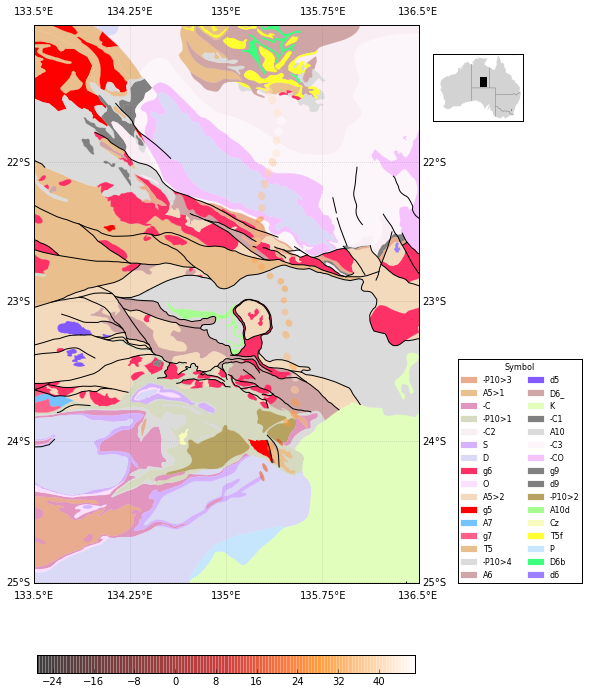

In [42]:
def drawBBox( minLon, minLat, maxLon, maxLat, bm, **kwargs):
    bblons = np.array([minLon, maxLon, maxLon, minLon, minLon])
    bblats = np.array([minLat, minLat, maxLat, maxLat, minLat])
    
    x, y = bm( bblons, bblats )
    xy = zip(x,y)
    poly = Polygon(xy)
    bm.ax.add_patch(PolygonPatch(poly, **kwargs))
#end func

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution='c', # c, l, i, h, f or None
            ax=ax,
            projection='merc',
            lat_0=-22, lon_0=135,
            llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat)

# draw lat-lon grids
m.drawparallels(np.linspace(minLat, maxLat, 5), labels=[1,1,0,0], linewidth=0.1)
m.drawmeridians(np.linspace(minLon, maxLon, 5), labels=[0,0,1,1], linewidth=0.1)

# plot geology ===================================================================

# plot polygons using a color lookup table
h,l = polyData.plot(ax, m, lutfn=lutFN, linewidth=0.2, edgecolor='face', rasterized=True, alpha=1)

# plot line data
lineData.plot(ax, m, alpha=1, color='k', linewidth=1.0)

# create legend including all symbols used in the plot
leg = ax.legend(h, l, loc=3,
                  bbox_to_anchor=(1.1, 0),
                  borderaxespad=0,
                  handlelength=2,
                  title= 'Symbol',
                  ncol=2,
                  fontsize=8)
leg.get_title().set_fontsize(8)

# plot inset =====================================================================
insetAx = fig.add_axes([0.8,0.75,0.125,0.125])
mInset = Basemap(resolution='c', # c, l, i, h, f or None
            ax=insetAx,
            projection='merc',
            lat_0=-20, lon_0=132,
            llcrnrlon=110, llcrnrlat=-40, urcrnrlon=155, urcrnrlat=-10)
#mInset.drawcoastlines()
mInset.fillcontinents(color='lightgray')
mInset.drawstates(color="grey")

drawBBox(minLon, minLat, maxLon, maxLat, mInset, fill='True', facecolor='k')

# plot phase tensors =============================================================
# fetch attribute to color phase tensor ellipses with
cmapAttrib = modemPT.get_period_attributes(16, 'phimin')
sm = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=np.min(cmapAttrib), 
                                                 vmax=np.max(cmapAttrib)),
                       cmap='gist_heat')
# extract color values from colormap
cvals = sm.cmap(sm.norm(cmapAttrib))
modemPT.plot(ax, m, periodIdx=16, cvals=cvals, edgecolor='none', alpha=0.5)

# show colormap
cbax = fig.add_axes([0.25,0,0.525,.025])
cbar = mpl.colorbar.ColorbarBase(cbax, cmap=sm.cmap,
                                 norm = sm.norm,
                                 orientation='horizontal',
                                 alpha=0.5)
#cbar.solids.set_edgecolor("face", alpha=0.5)

plt.savefig('/tmp/a.pdf', dpi=300)

## Load Magnetics

In [6]:
# load magnetics 
magFN = '../data/magnetics/magLowRes.nc'
mag = Dataset(magFN)

# print variable names to be able to access the raw data
print mag.variables

OrderedDict([(u'lon', <type 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    long_name: longitude
    units: degrees_east
    actual_range: [ 133.50960704  136.51043917]
unlimited dimensions: 
current shape = (301,)
filling off
), (u'lat', <type 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    long_name: latitude
    units: degrees_north
    actual_range: [-25.00690511 -21.00524004]
unlimited dimensions: 
current shape = (401,)
filling off
), (u'z', <type 'netCDF4._netCDF4.Variable'>
float32 z(lat, lon)
    long_name: z
    _FillValue: nan
    actual_range: [-1887.55480957  4829.68603516]
unlimited dimensions: 
current shape = (401, 301)
filling off
)])


In [7]:
# Load the raw data
maglons = mag.variables['lon'][:]
maglats = mag.variables['lat'][:]
magvs = mag.variables['z'][:]

maglons, maglats = np.meshgrid(maglons, maglats)

# project lats and lons
magpx, magpy = m(maglons, maglats)


## Show Raster Data Overlain by Phase Tensors


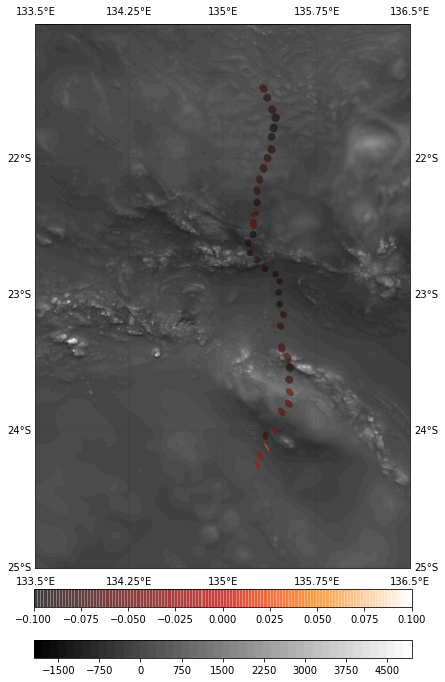

In [8]:
# plot magnetics and phase tensors
# set plot extents and dimensions
minLat = -25
maxLat = -21
minLon = 133.5
maxLon = 136.5

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution='c', # c, l, i, h, f or None
            ax=ax,
            projection='merc',
            lat_0=-22, lon_0=135,
            llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat)

# draw lat-lon grids
m.drawparallels(np.linspace(minLat, maxLat, 5), labels=[1,1,0,0], linewidth=0.1)
m.drawmeridians(np.linspace(minLon, maxLon, 5), labels=[0,0,1,1], linewidth=0.1)

# plot magnetics
c = m.contourf(magpx, magpy, magvs, 50, cmap='gray', rasterized=True)
cbax1 = fig.add_axes([0.25,0,0.525,0.025])
fig.colorbar(c, cbax1, orientation='horizontal')

# plot phase tensors
modemPT.plot(ax, m, periodIdx=16, cvals=cvals, alpha=0.5)
cbax2 = fig.add_axes([0.25,0.07,0.525,0.025])
cbar = mpl.colorbar.ColorbarBase(cbax2, cmap=sm.cmap,
                                 norm = sm.norm,
                                 orientation='horizontal',
                                 alpha=0.5)